# Exploring the error distributions
Here we compare the various aspects of the noise distributions for the error models - the real data, and various Blensor settings. Used in the Simulation section of the thesis.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from thesis.utils import laser_angle_to_id
import seaborn as sns
from scipy.stats import wasserstein_distance
plt.rcParams.update({'font.size': 22})
path_lut = {
    "real": "/scratch/users/branisj/error_data/error_measurements/distances",
    "none": "/scratch/users/branisj/error_data/new_virtual_error_measurements/none",
    "default": "/scratch/users/branisj/error_data/new_virtual_error_measurements/default",
    "base_vlp16": "/scratch/users/branisj/error_data/new_virtual_error_measurements/base_vlp16",
    "divergence": "/scratch/users/branisj/error_data/new_virtual_error_measurements/divergence",
    "incidence": "/scratch/users/branisj/error_data/new_virtual_error_measurements/incidence"
}
error2label = {
    "real": "Real noise",
    "none": "No noise",
    "default": "Default (HDL-64E)",
    "base_vlp16": "VLP-16",
    "divergence": "Beam divergence",
    "incidence": "Incidence angle"
}


In [2]:
raw = {}
distances = range(1, 6)
runs = range(1, 2)
kinds = ["wall", "floor"]
error_models = ["real", "none", "default", "base_vlp16", "divergence",  "incidence"]

for error in error_models:
    raw[error] = {}
    for kind in ["wall", "floor"]:
        raw[error][kind] = {}
        for dist in distances:
            raw[error][kind][dist] = {}
            for run in runs:
                if error == "real":
                    filename = f"{path_lut[error]}/{dist}m_{run}_distances_{kind}.txt"
                else:
                    filename = f"{path_lut[error]}/{dist}m_{run}_{kind}.txt"
                d =  np.loadtxt(filename)
                raw[error][kind][dist][run] = d

cols = ['Value', 'X', 'Y', 'Z', "unknown", 'Angle', 'Kind', 'Distance', 'Run']
df = pd.DataFrame(columns=cols)
pdfs = []
for error in error_models:
    for kind in ["wall", "floor"]:
        for dist in distances:
            for run in runs:
                data = raw[error][kind][dist][run]
                pdf = pd.DataFrame(data, columns=['Value', 'X', 'Y', 'Z', "unknown", 'Angle'])
                pdf = pdf.drop(columns=["unknown"])
                pdf["Kind"] = kind
                pdf["Distance"] = dist
                pdf["Run"] = run
                pdf["Error"] = error
                pdf = pdf.set_index(["Kind", "Distance", "Run", "Error"])
                pdfs.append(pdf)

df = pd.concat(pdfs)
df["Laser ID"] = df["Angle"].map(laser_angle_to_id)
df = df.set_index(["Laser ID"], append=True)
df

Value         X         Y         Z  \
Kind  Distance Run Error     Laser ID                                           
wall  1        1   real      0         0.012746  0.454609  0.938299 -0.182794   
                             1         0.004158  0.460264  0.949794  0.103589   
                             2         0.003651  0.458821  0.946969 -0.147784   
                             3         0.009431  0.458190  0.945492  0.138719   
                             4        -0.002207  0.461620  0.952724 -0.112148   
...                                         ...       ...       ...       ...   
floor 5        1   incidence 0         0.013205  0.750966  0.076606 -0.010844   
                             0         0.009385  0.756406  0.097529 -0.006899   
                             0         0.004801  0.761195  0.122179 -0.002189   
                             0         0.004176  0.768949  0.127528 -0.001447   
                             0         0.006643  0.779088  0.117832 -0.003802   

                                       Angle  
Kind  Distance Run Error     Laser ID         
wall  1        1   real      0         -15.0  
                             1           1.0  
                             2         -13.0  
                             3           3.0  
                             4         -11.0  
...                                      ...  
floor 5        1   incidence 0         -15.0  
                             0         -15.0  
                             0         -15.0  
                             0         -15.0  
                             0         -15.0  

[17101678 rows x 5 columns]

real 4854
none 5108
base_vlp16 5046
divergence 5025


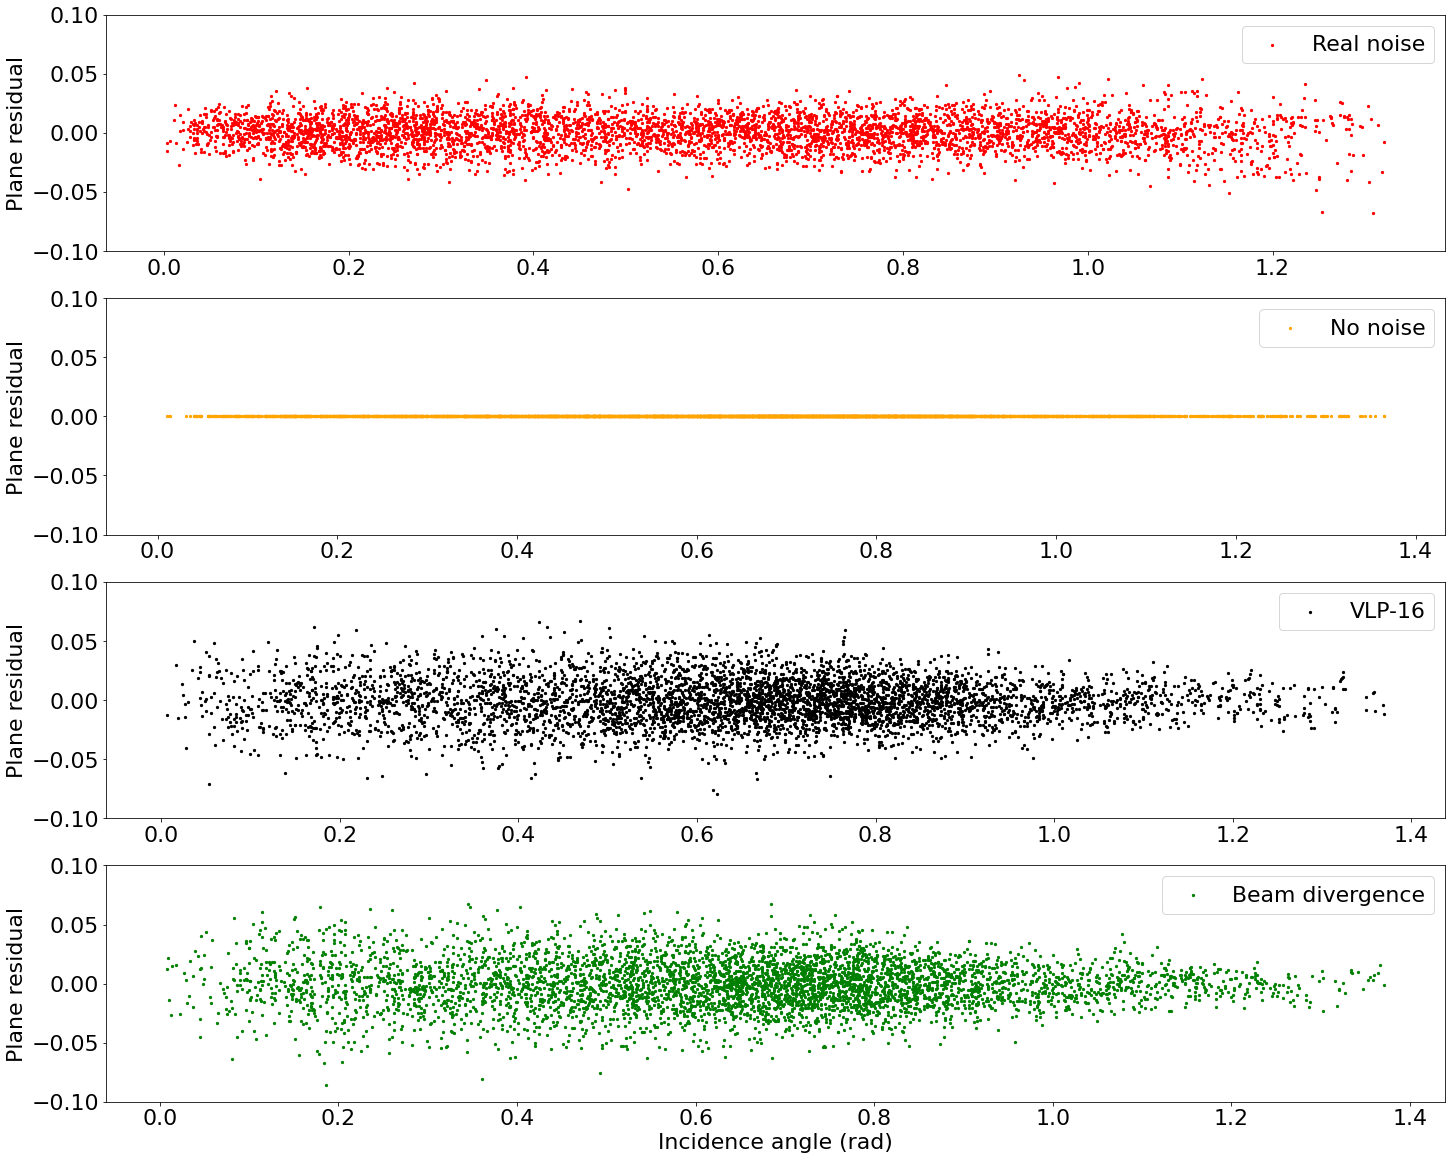

In [476]:

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def get_incidence_angle(x, y, z, dist, kind, error):
    scanner_position = np.array([0, 0, 0]) if error == "real" else np.array([0, dist, 1])
    start = scanner_position
    end = np.array([x,y,z])
#     end = np.array([0, 1, 0])
    v =  end - start
    wall_normal = np.array([0, -1, 0]) if error == "real" else np.array([0, 1, 0])
    floor_normal = np.array([0, 0, 1])
    n = wall_normal if kind == "wall" else floor_normal
    return -(angle_between(v, n) - np.pi)
# Maybe we dont need to correct the incident angle (we are in world coords)

# Between scanner and point, x is left to right, y is distance between and z is up and down
df_reset = df.sample(30000).reset_index()
df_reset["Incidence"] = [get_incidence_angle(*a) for a in tuple(zip(df_reset["X"], df_reset["Y"], df_reset["Z"], df_reset["Distance"], df_reset["Kind"], df_reset["Error"]))]

colors_by_kind = { "wall": "red", "floor": "blue"}
colors_by_error = { "real": "red", "none": "orange", "default": "blue", "base_vlp16": "black", "divergence": "green", "incidence": "purple"}
fig, axes = plt.subplots(figsize=(24, 20), nrows=4, ncols=1)
error_models_reduced = ["real", "none", "base_vlp16", "divergence"]
grouped = df_reset.set_index("Error").loc[error_models_reduced].groupby('Error', sort=False)
counter = 0
for key, group in grouped:
    print(key, len(group))
    group.plot.scatter(ax=axes[counter], x="Incidence", y="Value", ylabel="Plane residual", xlabel="", marker='.',color=colors_by_error[key], label=error2label[key], ylim=[-0.1, 0.1])
    counter = counter + 1
plt.xlabel("Incidence angle (rad)")
fig.savefig("plots/d_comparison_no_incidence.png", bbox_inches='tight', pad_inches=1)

plt.show()




Incidence
(0.00553, 0.137]    0.001502
(0.137, 0.268]      0.000986
(0.268, 0.398]      0.000516
(0.398, 0.529]      0.000266
(0.529, 0.659]      0.000445
(0.659, 0.789]      0.000820
(0.789, 0.92]       0.001028
(0.92, 1.05]       -0.000098
(1.05, 1.181]      -0.001631
(1.181, 1.311]     -0.001680
Name: Value, dtype: float64

Incidence
(0.00553, 0.137]    0.011727
(0.137, 0.268]      0.012315
(0.268, 0.398]      0.014653
(0.398, 0.529]      0.014025
(0.529, 0.659]      0.012515
(0.659, 0.789]      0.012653
(0.789, 0.92]       0.013284
(0.92, 1.05]        0.013237
(1.05, 1.181]       0.016266
(1.181, 1.311]      0.027907
Name: Value, dtype: float64

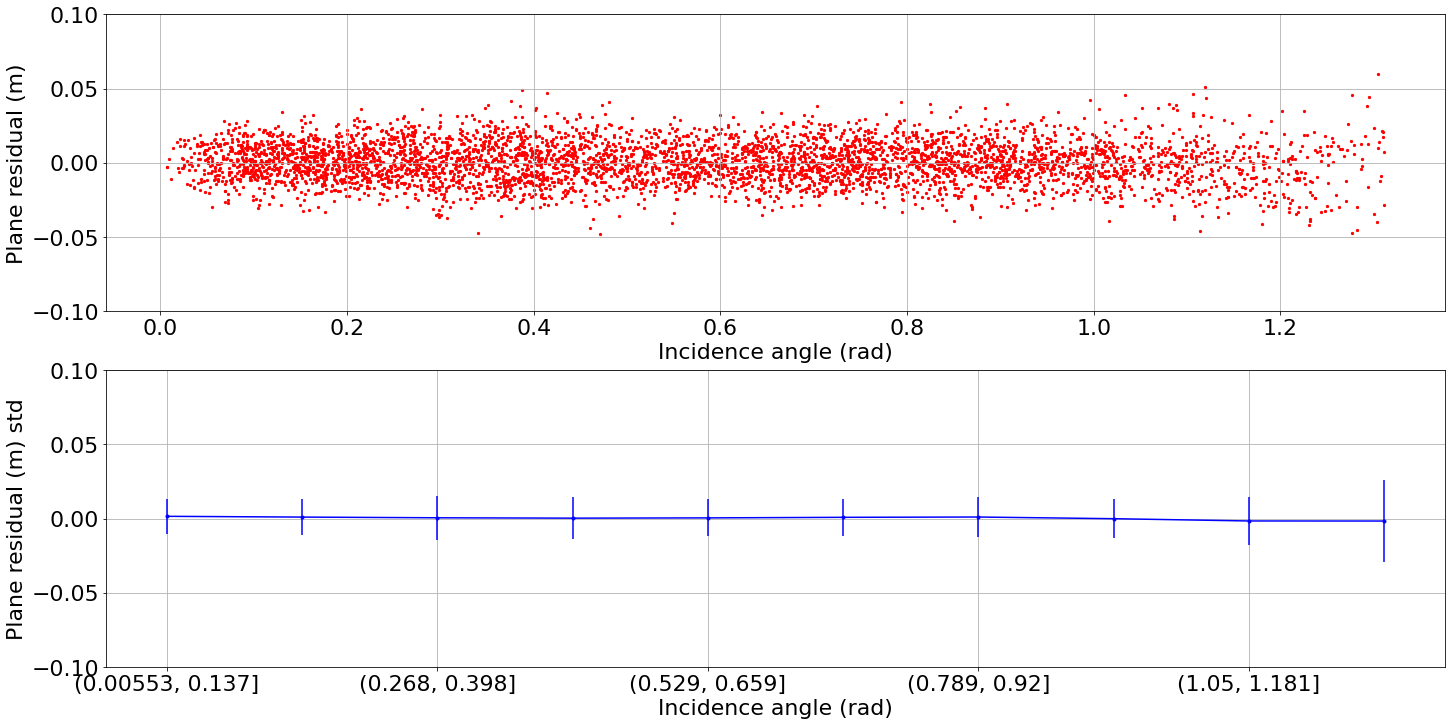

In [391]:
fig, axes = plt.subplots(figsize=(24,12), nrows=2)
real = df_reset[df_reset["Error"] == 'real']

real.plot.scatter(ax=axes[0], x="Incidence", y="Value",ylabel="Plane residual (m)", grid=True, xlabel="Incidence angle (rad)", marker='.',color=colors_by_error[key], ylim=[-0.1, 0.1])
bins = pd.cut(real['Incidence'], 10, )
real_mean = real.groupby(bins)["Value"].mean()
real_std = real.groupby(bins)["Value"].std()

display(real_mean)
display(real_std)

# real_mean["variance"] = real_mean["Value"]**2
real_mean.plot.line(ax=axes[1], x="Incidence", y="Value", yerr=real_std, grid=True, ylabel="Plane residual (m) std", xlabel="Incidence angle (rad)", marker='.',color="blue", label=key, ylim=[-0.1, 0.1])

# display(real_mean)

plt.show()
fig.savefig("plots/d_real_incidence.png", bbox_inches='tight', pad_inches=1)


In [243]:
def plot_per_distance(data, kind):
    kind_data = df.loc[kind]
    fig, axes = plt.subplots(nrows=1, ncols=5)
    fig.set_figwidth(24)
    fig.set_figheight(5)
    means = kind_data.groupby(["Distance", "Angle"]).mean().reset_index()
    std = kind_data.groupby(["Distance", "Angle"]).std().reset_index()
    for dist in range(1, 6):
        _means = means[means["Distance"] == dist].pivot(index='Angle', columns='Distance', values='Value')
        _std = std[std["Distance"] == dist].pivot(index='Angle', columns='Distance', values='Value')
        _means.plot(kind="line", ax=axes[dist-1], title=f"{kind.capitalize()} ({dist}m)", yerr=_std)

# plot_per_distance(df, "wall")
# plot_per_distance(df, "floor")

In [244]:
def plot_per_laser(data, kind):
    kind_data = df.loc[kind]
    fig, axes = plt.subplots(nrows=4, ncols=4)
    fig.set_figwidth(24)
    fig.set_figheight(24)
    means = kind_data.groupby(["Distance", "Angle"]).mean().reset_index()
    std = kind_data.groupby(["Distance", "Angle"]).std().reset_index()
    counter = 0
    for angle in range(-15, 16, 2):
        _means = means[means["Angle"] == angle].pivot(index='Distance', columns='Angle', values='Value')
        _std = std[std["Angle"] == angle].pivot(index='Distance', columns='Angle', values='Value')
        j = counter % 4
        i = counter // 4
        _means.plot(kind="line", ax=axes[i, j], title=f"{kind.capitalize()} ({angle})", yerr=_std)
        counter = counter + 1

# plot_per_laser(df, "wall")
# plot_per_laser(df, "floor")

Error model: real
Mean: 0.0006364833271177368
Standard deviation: 0.013836383542912549
Earth mover's distance 0.0

Error model: none
Mean: 3.7362692448561725e-08
Standard deviation: 2.6780552159612063e-07
Earth mover's distance 0.010916752476816526

Error model: default
Mean: -0.0008728907622259854
Standard deviation: 0.06438881543249875
Earth mover's distance 0.03919410763289197

Error model: base_vlp16
Mean: -0.0012851332848567835
Standard deviation: 0.018560615748246693
Earth mover's distance 0.004237880269883412

Error model: divergence
Mean: -0.00020496601191781635
Standard deviation: 0.02004533960131418
Earth mover's distance 0.004896563346569146



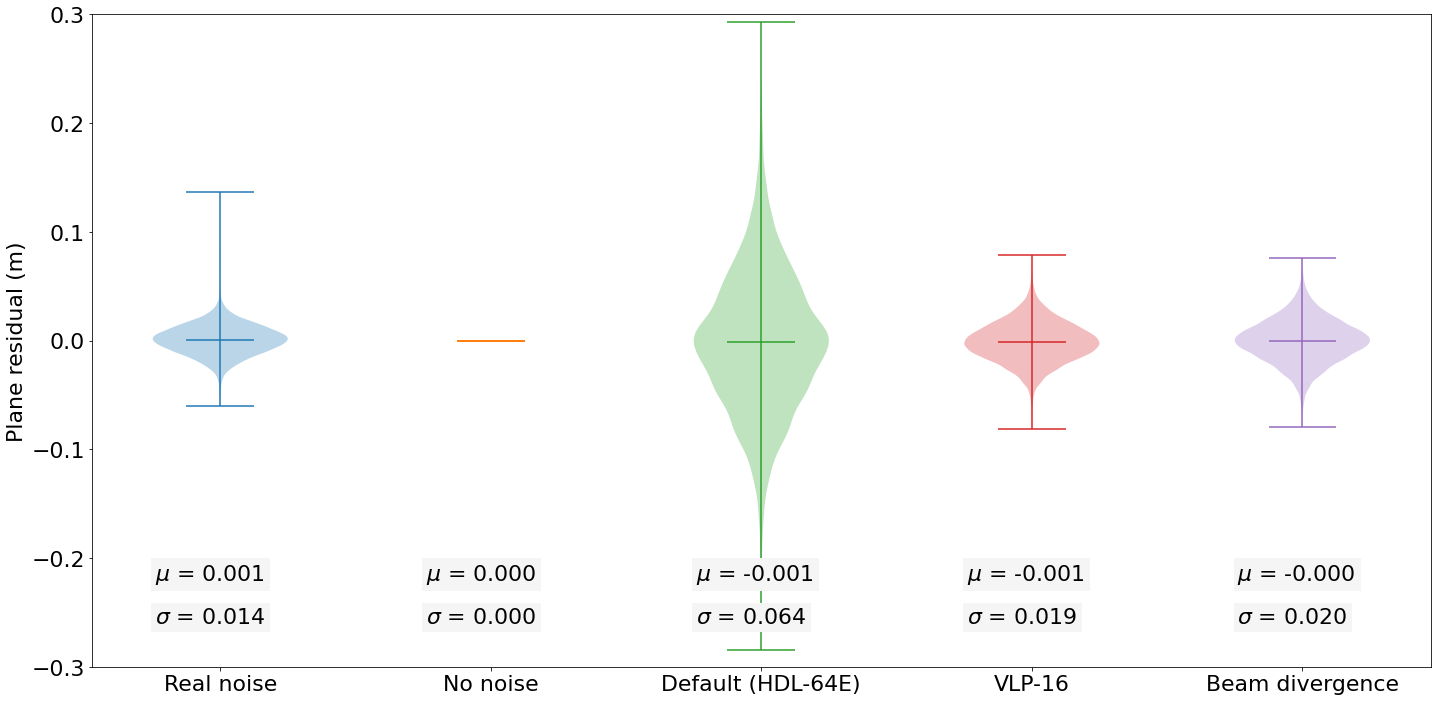

In [455]:


error_models_without_ind = ["real", "none", "default", "base_vlp16", "divergence"]

def plot_violin(data):
    fig = plt.figure()
    fig.set_figwidth(24)
    fig.set_figheight(12)
    for i, error in enumerate(error_models_without_ind):
        plt.violinplot(data.query("Error == @error")["Value"], positions=[i], showmeans=True)
        print(f"Error model: {error}")
        mean = data.query("Error == @error")["Value"].mean()
        std = data.query("Error == @error")["Value"].std()
        w = wasserstein_distance(data.query("Error == 'real'")["Value"], data.query("Error == @error")["Value"])
        print("Mean:", mean)
        print("Standard deviation:", std)
        print("Earth mover's distance", w)
        print()
        plt.text(i - 0.24, -0.22, f"$\mu$ = {mean:.3f}", backgroundcolor="whitesmoke")
        plt.text(i - 0.24, -0.26, f"$\sigma$ = {std:.3f}",  backgroundcolor="whitesmoke")

    plt.ylim(-0.3, 0.3)
    plt.xticks(range(len(error_models_without_ind)), labels=[error2label[x] for x in error_models_without_ind])
    plt.ylabel("Plane residual (m)")
    fig.savefig("plots/v_comparison_no_incidence.png", bbox_inches='tight', pad_inches=1)
    plt.show()

plot_violin(df.sample(100000))
# plot_violin(df.query("Error == 'default'"))


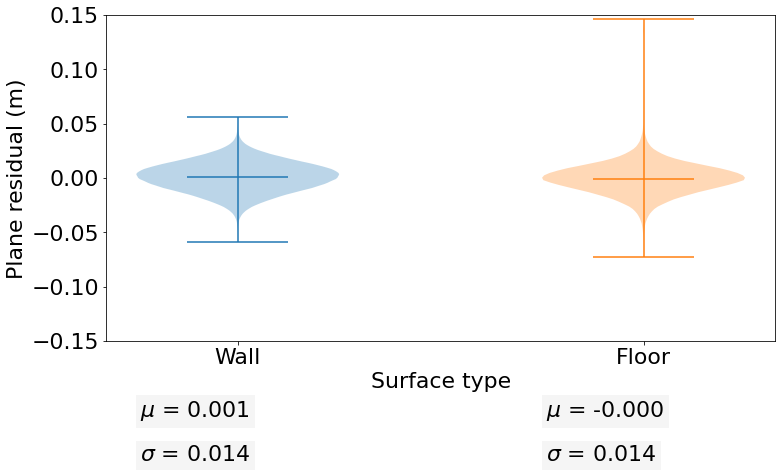

In [6]:
def plot_violin(data):
    fig = plt.figure()
    fig.set_figwidth(12)
    fig.set_figheight(6)
    for i, kind in enumerate(["wall", "floor"]):
        kind_data = data.loc[kind]
        plt.violinplot(kind_data["Value"], positions=[i],showmeans=True)
        mean = kind_data["Value"].mean()
        std = kind_data["Value"].std()
    plt.xticks([0,1], labels=["Wall", "Floor"])
    plt.ylim(-0.15, 0.15)
    plt.xlabel("Surface type")
    plt.ylabel("Plane residual (m)")
    fig.savefig("plots/v_real_surface_comparison.png", bbox_inches='tight', pad_inches=1)
    plt.show()

plot_violin(df.query("Error == 'real'"))


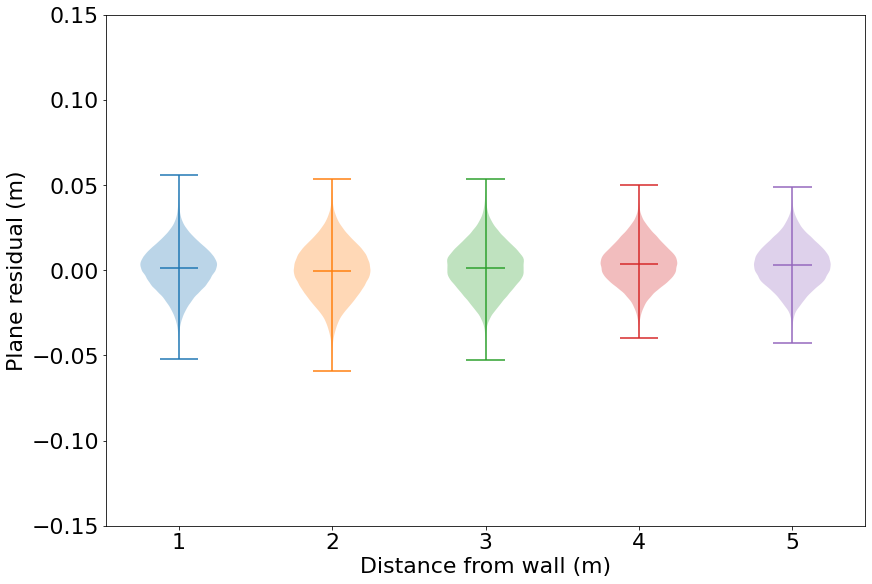

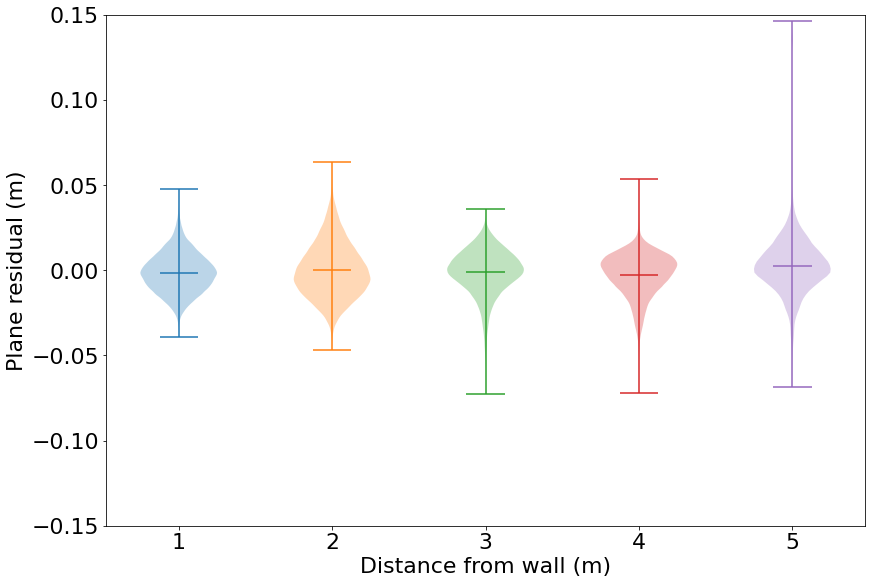

In [21]:
def plot_violin_per_distance(data, kind):
    kind_data = data.loc[kind]
    fig = plt.figure(constrained_layout=True)
    fig.set_figwidth(12)
    fig.set_figheight(8)
    for dist in range(1, 6):
        plt.violinplot(kind_data.loc[dist]["Value"], positions=[dist-1], showmeans=True)
    plt.xticks(range(5), labels=range(1, 6))
    plt.ylim(-0.15, 0.15)
    plt.xlabel("Distance from wall (m)")
    plt.ylabel("Plane residual (m)")
    fig.savefig(f"plots/v_real_dist_comparison_{kind}.png", bbox_inches='tight', pad_inches=1)
    plt.show()

plot_violin_per_distance(df.query("Error == 'real'"), "wall")
plot_violin_per_distance(df.query("Error == 'real'"), "floor")

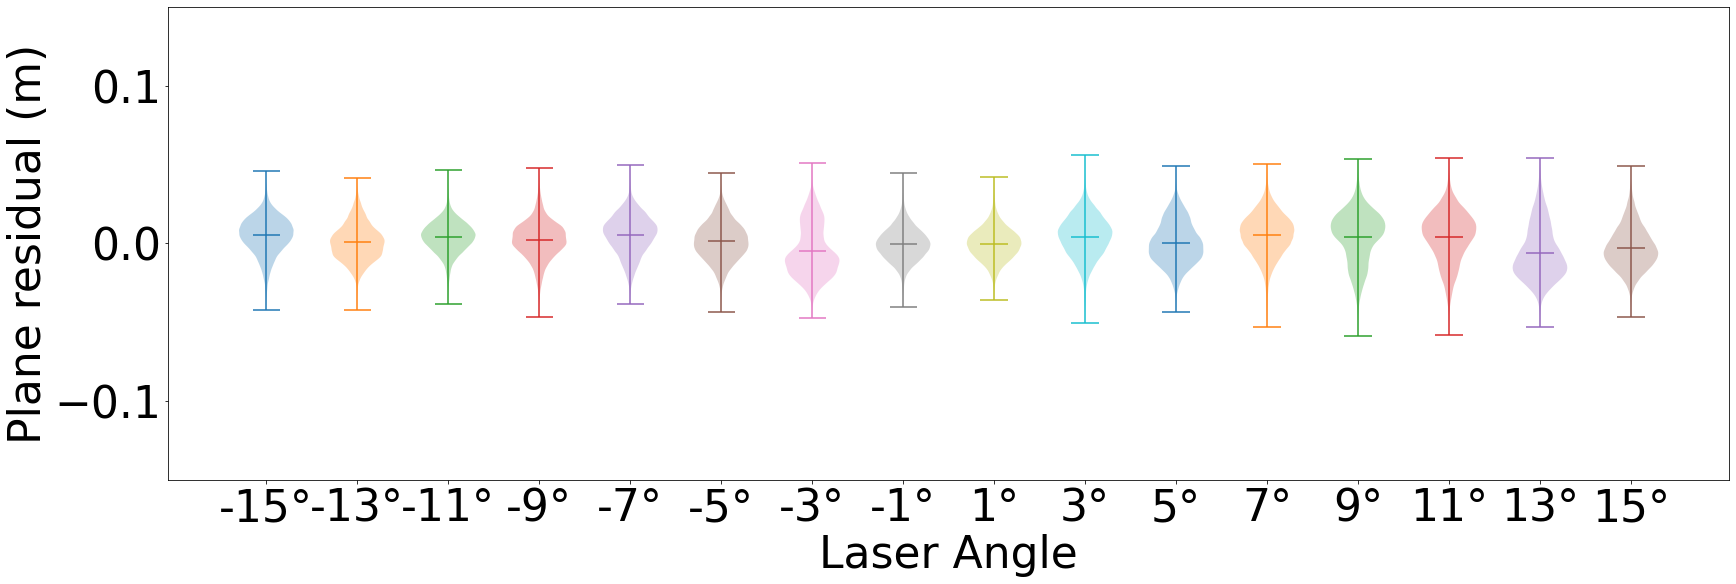

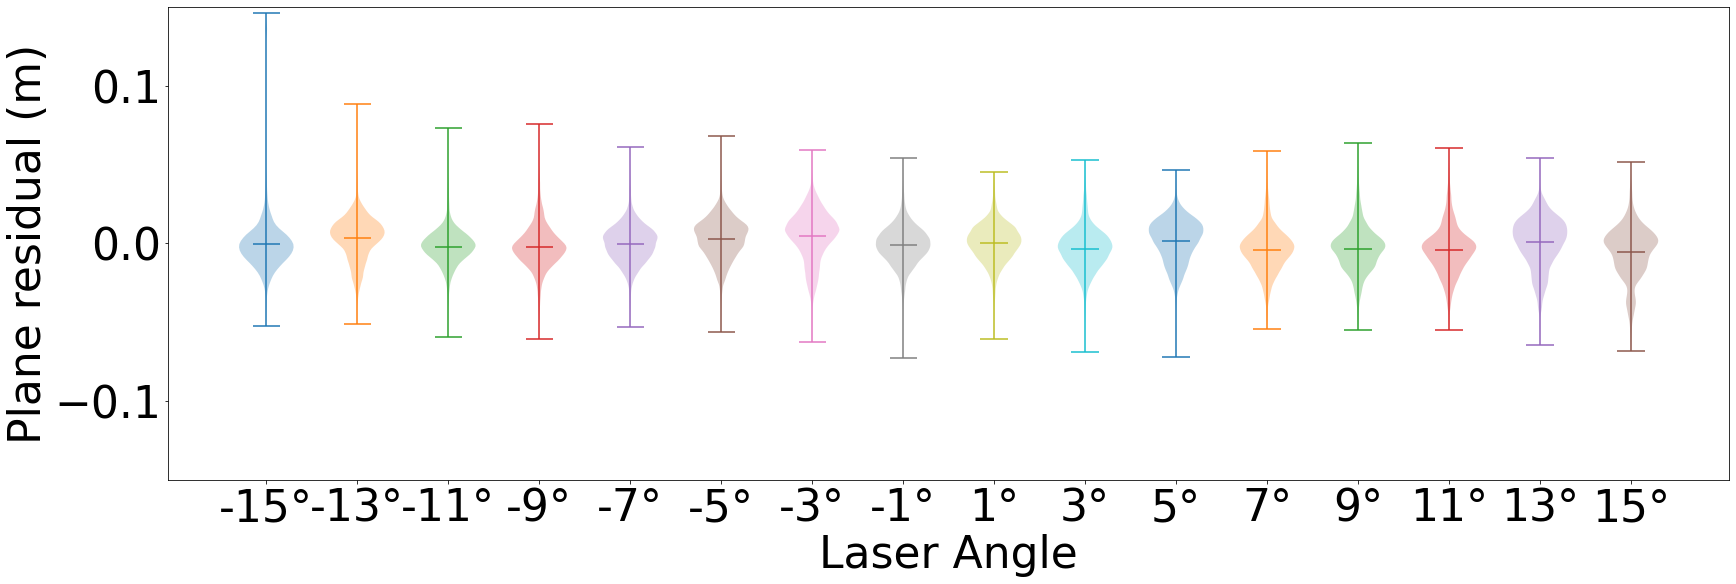

In [23]:
def plot_violin_per_laser(data, kind):
    kind_data = data.loc[kind]
    kind_data = kind_data.swaplevel(0, 4)
    fig = plt.figure(constrained_layout=True)
    fig.set_figwidth(24)
    fig.set_figheight(8)
    for laser in range(-15, 16, 2):
        plt.violinplot(kind_data.loc[laser]["Value"], positions=[laser], showmeans=True, widths=1.2)
    plt.xticks(range(-15, 16, 2), labels=[f"{x}°" for x in range(-15, 16, 2)])
    plt.ylim(-0.15, 0.15)
    plt.xlabel("Laser Angle")
    plt.ylabel("Plane residual (m)")
    fig.savefig(f"plots/v_real_laser_comparison_{kind}.png", bbox_inches='tight', pad_inches=1)
    plt.show()
df2 = df.set_index(["Angle"], append=True)
plt.rcParams.update({'font.size': 44})

plot_violin_per_laser(df2.query("Error == 'real'"), "wall")
plot_violin_per_laser(df2.query("Error == 'real'"), "floor")
plt.rcParams.update({'font.size': 22})


In [191]:
def find_extremes(data, kind):
    kind_data = df.loc[kind]
    display(kind_data.sort_values(by="Value", ascending=False).head(20))

find_extremes(df, "wall")
find_extremes(df, "floor")

Value         X         Y         Z  Angle
Distance Run Laser ID                                               
1        3   13        0.074351  0.936901  0.790673 -0.636818   13.0
             13        0.073932  0.943565  0.784781 -0.767209   13.0
             13        0.073190  0.933380  0.788838 -0.767986   13.0
             13        0.073118  0.920597  0.794870 -0.769701   13.0
             13        0.071142  0.940401  0.783241 -0.765143   13.0
             13        0.071079  0.927832  0.789180 -0.766863   13.0
         2   12        0.070806  0.938603  0.807405 -0.683811   -3.0
         3   13        0.070559  0.774156  0.862313 -0.773851   13.0
         2   13        0.070528  0.892196  0.825022 -0.760122   13.0
         3   13        0.070305  0.917478  0.793283 -0.767604   13.0
             13        0.070067  0.671873  0.910832 -0.778110   13.0
             13        0.069964  0.942676  0.780977 -0.757106   13.0
             13        0.069309  0.907729  0.796854 -0.768040   13.0
             12        0.069151  0.916344  0.790931 -0.862283   -3.0
             13        0.069015  0.830189  0.833579 -0.779756   13.0
             13        0.069013  0.895132  0.802552 -0.769460   13.0
             13        0.068917  0.949224  0.774371 -0.891868   13.0
             13        0.068886  0.940884  0.782778 -0.632034   13.0
         2   13        0.068878  0.829774  0.847771 -0.843067   13.0
         3   12        0.068573  0.894667  0.802435 -0.760843   -3.0

Value         X        Y         Z  Angle
Distance Run Laser ID                                              
5        2   15        0.467938  0.906736  4.20948 -0.722117   15.0
             15        0.273884  0.908892  4.24380 -0.918481   15.0
         1   0         0.146080 -0.045021  4.79635 -1.383630  -15.0
             0         0.145128  0.174039  4.77269 -1.383230  -15.0
             0         0.145055 -0.548686  4.76319 -1.375680  -15.0
             0         0.144803  0.327222  4.76037 -1.383560  -15.0
             0         0.144590  0.277640  4.76366 -1.383090  -15.0
             0         0.144448  0.243167  4.76564 -1.382750  -15.0
             0         0.144437  0.240363  4.76579 -1.382720  -15.0
             0         0.144308  0.207558  4.76743 -1.382390  -15.0
             0         0.144141 -0.465038  4.76785 -1.375860  -15.0
             0         0.144120 -0.511984  4.76326 -1.375100  -15.0
             0         0.144073 -0.092962  4.78820 -1.380630  -15.0
             0         0.143962 -0.142799  4.78716 -1.379980  -15.0
             0         0.143893 -0.176579  4.78616 -1.379530  -15.0
             0         0.143698  0.290578  4.75902 -1.382020  -15.0
             0         0.143369  0.324034  4.75486 -1.381740  -15.0
             0         0.143189 -0.478813  4.76271 -1.374450  -15.0
             0         0.143175 -0.514233  4.75919 -1.373870  -15.0
             0         0.142944 -0.179109  4.78226 -1.378300  -15.0

In [6]:
df.to_pickle("distances.pkl") 

In [488]:
test = {}
for error in ["base_vlp16", "divergence"]:
    test[error] = {}
    for kind in ["wall", "floor"]:
        test[error][kind] = {}
        for dist in [30]:
            test[error][kind][dist] = {}
            for run in [0]:
                filename = f"/scratch/users/branisj/error_data/test_divergence/{error}_{dist}m_{run}_{kind}.txt"
                d =  np.loadtxt(filename)
                test[error][kind] = d

cols = ['Value', 'X', 'Y', 'Z', "unknown", 'Angle', 'Kind', 'Distance', 'Run']
df = pd.DataFrame(columns=cols)
pdfs = []
for error in ["base_vlp16", "divergence"]:
    for kind in ["wall", "floor"]:
        for dist in [30]:
            for run in [0]:
                data = test[error][kind]
                pdf = pd.DataFrame(data, columns=['Value', 'X', 'Y', 'Z', "unknown", 'Angle'])
                pdf = pdf.drop(columns=["unknown"])
                pdf["Kind"] = kind
                pdf["Distance"] = dist
                pdf["Run"] = run
                pdf["Error"] = error
                pdf = pdf.set_index(["Kind", "Distance", "Run", "Error"])
                pdfs.append(pdf)

df_test = pd.concat(pdfs)
df_test["Laser ID"] = df_test["Angle"].map(laser_angle_to_id)
df_test = df_test.set_index(["Laser ID"], append=True)
df_test

Value         X         Y  \
Kind  Distance Run Error      Laser ID                                 
wall  30       0   base_vlp16 15        0.015751 -0.758510  0.017225   
                              15        0.015967 -0.707935  0.016591   
                              15        0.007653 -0.657182  0.024484   
                              15       -0.000244 -0.606467  0.031960   
                              15        0.020731 -0.556309  0.010572   
...                                          ...       ...       ...   
floor 30       0   divergence 0         0.041614  0.516000  6.883270   
                              0         0.040331  0.553611  7.196860   
                              0         0.040850  0.649163  7.227050   
                              0         0.041046  0.690967  6.843890   
                              0         0.042186  0.708030  6.786710   

                                               Z  Angle  
Kind  Distance Run Error      Laser ID                   
wall  30       0   base_vlp16 15        0.391900   15.0  
                              15        0.391556   15.0  
                              15        0.391408   15.0  
                              15        0.391274   15.0  
                              15        0.390577   15.0  
...                                          ...    ...  
floor 30       0   divergence 0        -0.001224  -15.0  
                              0        -0.000617  -15.0  
                              0        -0.001240  -15.0  
                              0        -0.000646  -15.0  
                              0        -0.001673  -15.0  

[787387 rows x 5 columns]

Error model: base_vlp16
Mean: -0.005514068945082413
Standard deviation: 0.016299885814306633

Error model: divergence
Mean: -0.004950067929637332
Standard deviation: 0.017072218981790843



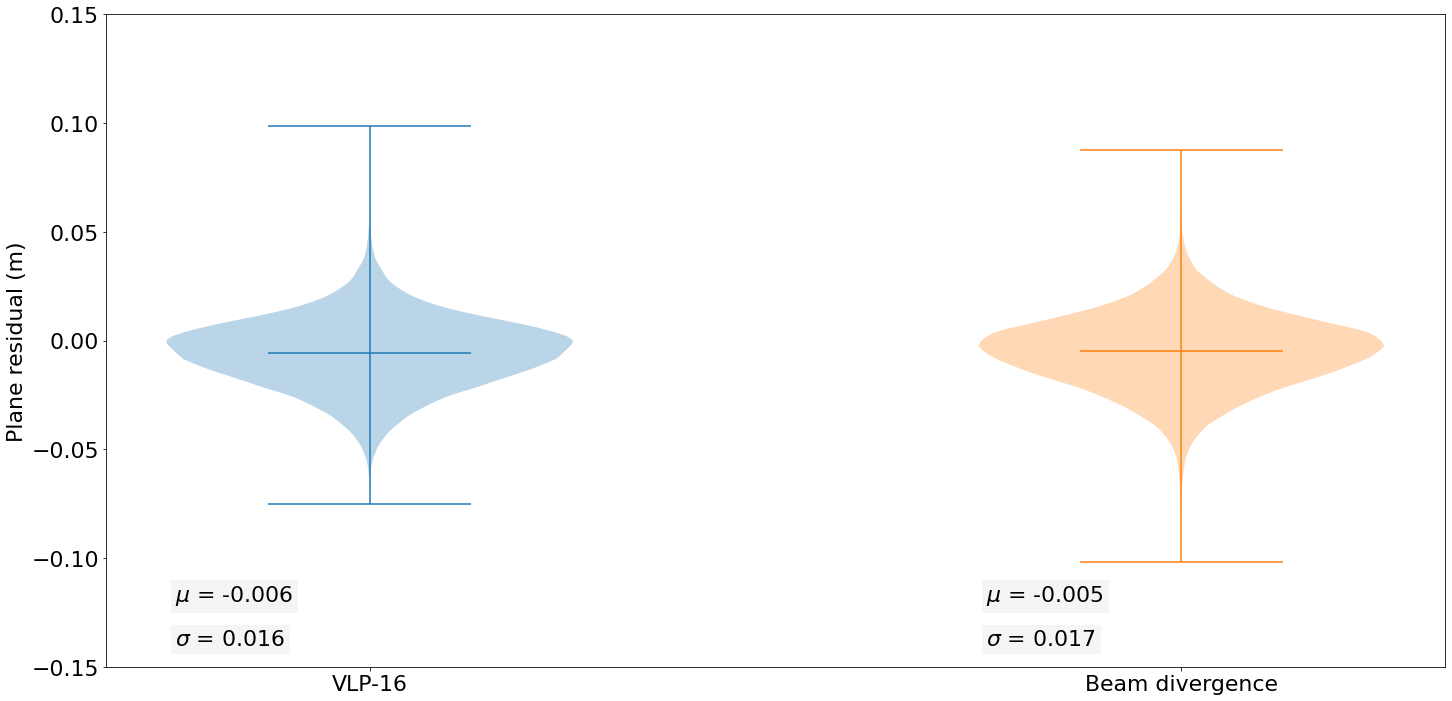

In [497]:

fig = plt.figure()
fig.set_figwidth(24)
fig.set_figheight(12)
for i, error in enumerate(["base_vlp16", "divergence"]):
    plt.violinplot(df_test.query("Error == @error" )["Value"], positions=[i], showmeans=True)
    print(f"Error model: {error}")
    mean = df_test.query("Error == @error")["Value"].mean()
    std = df_test.query("Error == @error")["Value"].std()
#         w = wasserstein_distance(data.query("Error == 'real'")["Value"], data.query("Error == @error")["Value"])
    print("Mean:", mean)
    print("Standard deviation:", std)
#         print("Earth mover's distance", w)
    print()
    plt.text(i - 0.24, -0.12, f"$\mu$ = {mean:.3f}", backgroundcolor="whitesmoke")
    plt.text(i - 0.24, -0.14, f"$\sigma$ = {std:.3f}",  backgroundcolor="whitesmoke")

plt.ylim(-0.15, 0.15)
plt.xticks(range(len(["base_vlp16", "divergence"])), labels=[error2label[x] for x in ["base_vlp16", "divergence"]])
plt.ylabel("Plane residual (m)")
fig.savefig("plots/v_long_distance.png", bbox_inches='tight', pad_inches=1)
plt.show()

